# Trabajo 3: Clasificación de Imágenes Médicas (Pneumonia Detection)
**Asignatura:** Visión por Computador  
**Objetivo:** Desarrollar y comparar un sistema de clasificación utilizando descriptores clásicos (*handcrafted*) vs. Deep Learning (CNN).

## Parte 1: Análisis Exploratorio y Preprocesamiento
En este notebook abordaremos las siguientes tareas:
1.  **Carga y Visualización:** Entender la estructura de los datos.
2.  **Análisis de Distribución:** Verificar el balance entre clases (Normal vs. Pneumonia).
3.  **Pipeline de Preprocesamiento:** Implementar normalización de tamaño y mejora de contraste mediante CLAHE.

In [2]:
#Importamos librerias
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import kagglehub

# Configuración para que los gráficos se vean bien en el notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

### 1. Configuración de Directorios
Definimos las rutas donde se encuentran descomprimidos los datos. La estructura es `data/train`, `data/test` y `data/val`.

In [3]:
# Descargar dataset automáticamente
print("Descargando dataset desde Kaggle...")

os.environ['KAGGLEHUB_CACHE'] = os.path.join(os.getcwd(), '../data')

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print(f"Dataset descargado en: {path}")

# La estructura del dataset descargado suele ser: path/chest_xray/chest_xray/...
# o path/chest_xray/...
# Vamos a detectar la carpeta raíz correcta
DOWNLOAD_DIR = Path(path)
if (DOWNLOAD_DIR / "chest_xray" / "chest_xray").exists():
    BASE_DIR = DOWNLOAD_DIR / "chest_xray" / "chest_xray"
elif (DOWNLOAD_DIR / "chest_xray").exists():
    BASE_DIR = DOWNLOAD_DIR / "chest_xray"
else:
    BASE_DIR = DOWNLOAD_DIR

print(f"Usando BASE_DIR: {BASE_DIR}")

# Configuración de rutas
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"
VAL_DIR = BASE_DIR / "val"

# Verificar que las rutas existen
print(f"Buscando datos en: {TRAIN_DIR.resolve()}")
if not TRAIN_DIR.exists():
    print("¡ALERTA! No se encuentra la carpeta data/train. Revisa la estructura.")
else:
    print("¡Rutas correctas!")

Descargando dataset desde Kaggle...


100%|██████████| 2.29G/2.29G [10:44<00:00, 3.82MB/s]

Extracting files...


Dataset descargado en: d:\Inteligencia Artificial\Semestre II\Vision por computador\Practica_3\clasificacion_imagenes_medicas\notebooks\../data\datasets\paultimothymooney\chest-xray-pneumonia\versions\2
Usando BASE_DIR: d:\Inteligencia Artificial\Semestre II\Vision por computador\Practica_3\clasificacion_imagenes_medicas\notebooks\..\data\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray
Buscando datos en: D:\Inteligencia Artificial\Semestre II\Vision por computador\Practica_3\clasificacion_imagenes_medicas\data\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\train
¡Rutas correctas!


### 2. Análisis de Distribución de Clases
Es fundamental conocer si el dataset está balanceado. Un desbalance severo puede sesgar al clasificador.
Contaremos cuántas imágenes hay en cada partición para las clases **NORMAL** y **PNEUMONIA**.

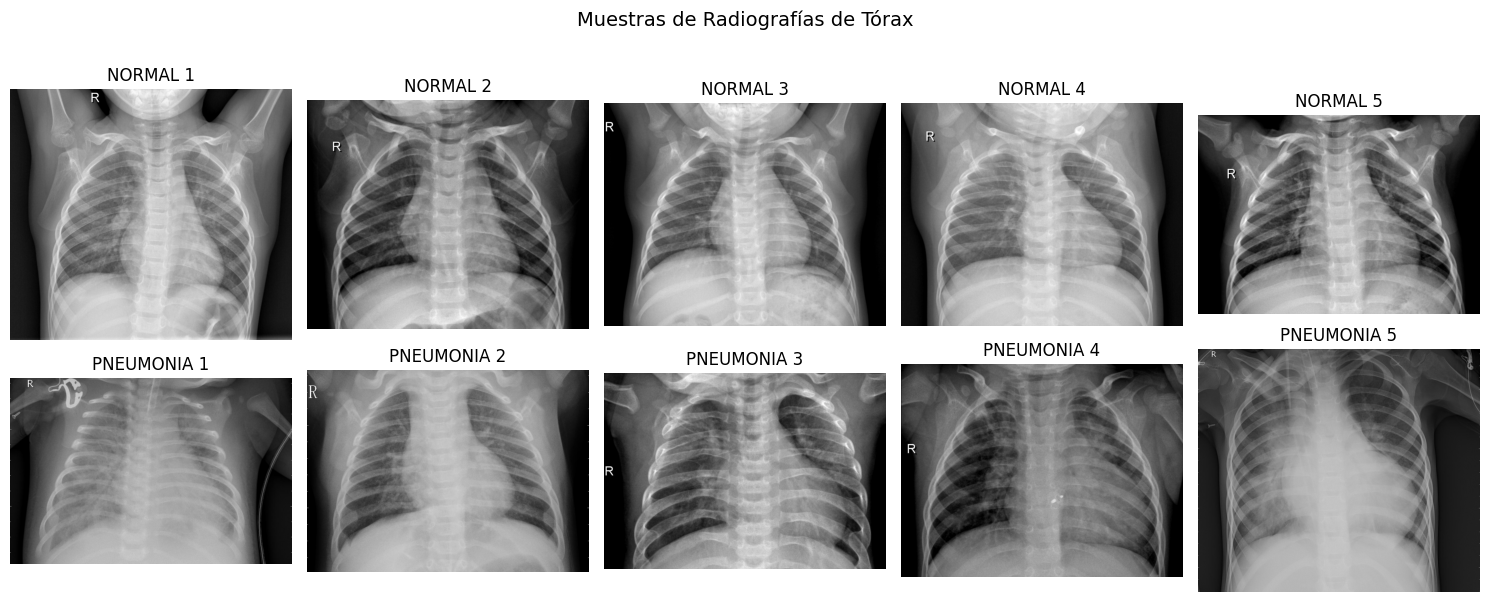

✅ Imagen guardada: results/figures/01_muestras_radiografias.png


In [9]:
# Cargar rutas de imágenes de train
train_normal_paths = sorted((TRAIN_DIR / "NORMAL").glob("*.jpeg"))
train_pneumonia_paths = sorted((TRAIN_DIR / "PNEUMONIA").glob("*.jpeg"))

# Visualizar muestras de ambas clases
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Mostrar imágenes NORMAL
for i, path in enumerate(train_normal_paths[:5]):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'NORMAL {i+1}')
    axes[0, i].axis('off')

# Mostrar imágenes PNEUMONIA
for i, path in enumerate(train_pneumonia_paths[:5]):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'PNEUMONIA {i+1}')
    axes[1, i].axis('off')

plt.suptitle('Muestras de Radiografías de Tórax', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../results/figures/01_muestras_radiografias.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada: results/figures/01_muestras_radiografias.png")

In [10]:
# Contar imágenes por clase en cada conjunto
datos_train = {
    'NORMAL': len(list((TRAIN_DIR / "NORMAL").glob("*.jpeg"))),
    'PNEUMONIA': len(list((TRAIN_DIR / "PNEUMONIA").glob("*.jpeg")))
}

datos_test = {
    'NORMAL': len(list((TEST_DIR / "NORMAL").glob("*.jpeg"))),
    'PNEUMONIA': len(list((TEST_DIR / "PNEUMONIA").glob("*.jpeg")))
}

datos_val = {
    'NORMAL': len(list((VAL_DIR / "NORMAL").glob("*.jpeg"))),
    'PNEUMONIA': len(list((VAL_DIR / "PNEUMONIA").glob("*.jpeg")))
}

print("=== CONTEO DE IMÁGENES POR CONJUNTO ===\n")
print(f"Train:      NORMAL={datos_train['NORMAL']}, PNEUMONIA={datos_train['PNEUMONIA']}")
print(f"Test:       NORMAL={datos_test['NORMAL']}, PNEUMONIA={datos_test['PNEUMONIA']}")
print(f"Validation: NORMAL={datos_val['NORMAL']}, PNEUMONIA={datos_val['PNEUMONIA']}")

=== CONTEO DE IMÁGENES POR CONJUNTO ===

Train:      NORMAL=1341, PNEUMONIA=3875
Test:       NORMAL=234, PNEUMONIA=390
Validation: NORMAL=8, PNEUMONIA=8


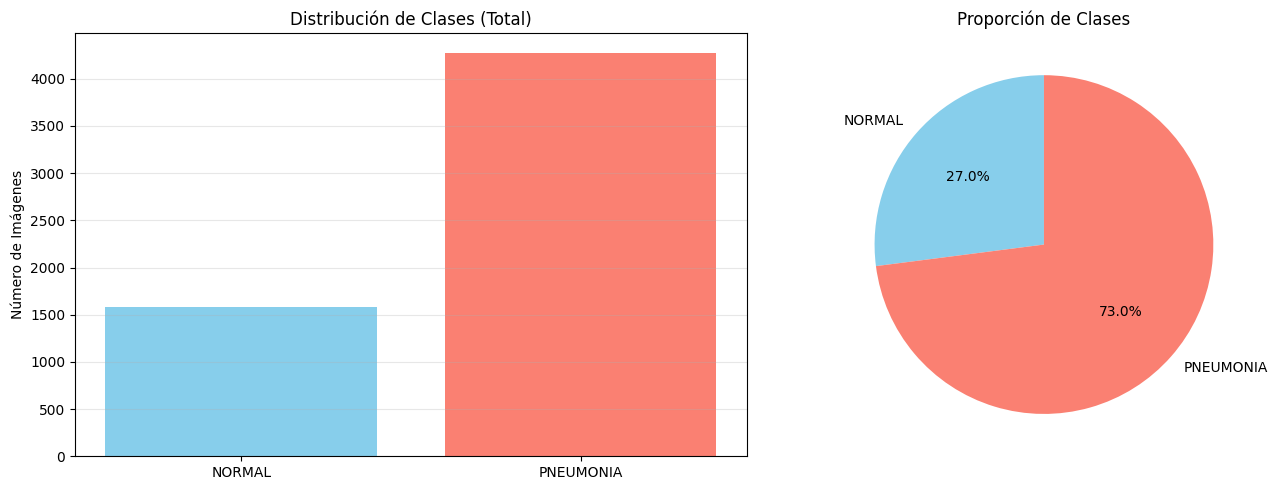

✅ Imagen guardada: results/figures/02_distribucion_clases.png


In [13]:
# Visualizar distribución de clases
datos_totales = {
    'NORMAL': datos_train['NORMAL'] + datos_test['NORMAL'] + datos_val['NORMAL'],
    'PNEUMONIA': datos_train['PNEUMONIA'] + datos_test['PNEUMONIA'] + datos_val['PNEUMONIA']
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(datos_totales.keys(), datos_totales.values(), color=['skyblue', 'salmon'])
axes[0].set_ylabel('Número de Imágenes')
axes[0].set_title('Distribución de Clases (Total)')
axes[0].grid(True, alpha=0.3, axis='y')

# Gráfico de torta
axes[1].pie(datos_totales.values(), labels=datos_totales.keys(), autopct='%1.1f%%',
            colors=['skyblue', 'salmon'], startangle=90)
axes[1].set_title('Proporción de Clases')

plt.tight_layout()
plt.savefig('../results/figures/02_distribucion_clases.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada: results/figures/02_distribucion_clases.png")

### Análisis del Desbalance de Clases

Tras realizar el conteo de imágenes en el conjunto de entrenamiento, observamos una distribución desigual significativa entre las clases:

| Clase | Cantidad | Porcentaje |
| :--- | :---: | :---: |
| **PNEUMONIA** | 3,875 | ~74.3% |
| **NORMAL** | 1,341 | ~25.7% |
| **Total** | 5,216 | 100% |

#### Implicaciones del Desbalance
Existe una proporción aproximada de **3:1** a favor de la clase *Pneumonia*. Este desbalance presenta desafíos críticos para el entrenamiento de modelos de clasificación:

1.  **Sesgo hacia la clase mayoritaria:** El modelo podría aprender a clasificar *todas* las imágenes como *Pneumonia* para minimizar el error global.
2.  **La "Paradoja del Accuracy":** Si nuestro modelo predijera ciegamente "Pneumonia" para el 100% de los casos, obtendría una **Exactitud (Accuracy) base del 74.3%**.
    * *Conclusión:* Un accuracy del 75% o 80% podría parecer bueno, pero en realidad apenas superaría al azar.

#### Estrategia de Mitigación
Dado este escenario, en la fase de clasificación (Parte 3) adoptaremos las siguientes medidas:

* **Métricas de Evaluación:** No confiaremos únicamente en el *Accuracy*. Priorizaremos el **F1-Score** y, sobre todo, el **Recall (Sensibilidad)**, ya que en medicina es crítico minimizar los Falsos Negativos (no diagnosticar a un paciente enfermo).
* **Validación Cruzada Estratificada:** Usaremos *Stratified K-Fold* en lugar de un split aleatorio simple, asegurando que cada "fold" de validación mantenga la misma proporción de clases que el set original.
* **Matrices de Confusión:** Serán obligatorias para visualizar si el modelo está ignorando la clase *NORMAL*.

### 3. Pipeline de Preprocesamiento
Para que los modelos (tanto clásicos como CNN) funcionen correctamente, aplicaremos dos transformaciones clave:

1.  **Normalización de Tamaño:** Las imágenes vienen en dimensiones variadas. Las estandarizaremos a **224x224** píxeles.
2.  **CLAHE (Contrast Limited Adaptive Histogram Equalization):** 

In [14]:
def preprocesar_imagen(ruta_imagen, tamaño_final=(224, 224), aplicar_clahe=True):
    """
    Lee una imagen, la convierte a escala de grises, redimensiona y aplica CLAHE.
    """
    # 1. Leer en escala de grises (cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(str(ruta_imagen), cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        return None

    # 2. Normalización de tamaño (Resize)
    img_resized = cv2.resize(img, tamaño_final)
    
    # 3. Ecualización de histograma CLAHE
    if aplicar_clahe:
        # clipLimit: Umbral para limitar el contraste (evita ruido excesivo)
        # tileGridSize: Tamaño de la rejilla local (8x8 es estándar)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_final = clahe.apply(img_resized)
    else:
        img_final = img_resized
        
    return img_final

### 4. Visualización de Resultados
Vamos a comparar una imagen original, una imagen solo redimensionada, y la imagen final con CLAHE. Esto nos permitirá justificar visualmente por qué el preprocesamiento ayuda a destacar características.

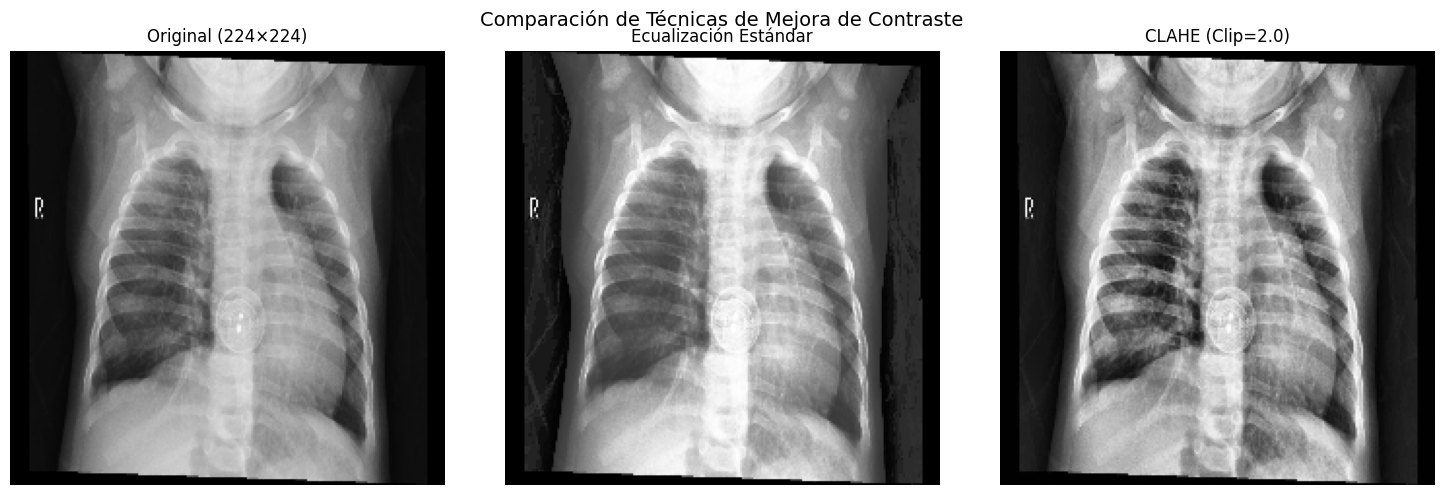

✅ Imagen guardada: results/figures/03_comparacion_clahe.png


In [15]:
# Cargar una imagen de ejemplo
sample_path = train_pneumonia_paths[10]  # Imagen con neumonía
img_original = cv2.imread(str(sample_path), cv2.IMREAD_GRAYSCALE)

# Redimensionar a 224x224
img_original_resized = cv2.resize(img_original, (224, 224))

# Aplicar CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_con_clahe = clahe.apply(img_original_resized)

# Sin CLAHE (solo ecualización estándar)
img_sin_clahe = cv2.equalizeHist(img_original_resized)

# Visualizar comparación
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_original_resized, cmap='gray')
axes[0].set_title('Original (224×224)')
axes[0].axis('off')

axes[1].imshow(img_sin_clahe, cmap='gray')
axes[1].set_title('Ecualización Estándar')
axes[1].axis('off')

axes[2].imshow(img_con_clahe, cmap='gray')
axes[2].set_title('CLAHE (Clip=2.0)')
axes[2].axis('off')

plt.suptitle('Comparación de Técnicas de Mejora de Contraste', fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig('../results/figures/03_comparacion_clahe.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada: results/figures/03_comparacion_clahe.png")

### 5. Análisis de Histogramas
Para verificar matemáticamente el efecto de CLAHE, graficaremos la distribución de intensidades de los píxeles.

* **Histograma Original:** Esperamos ver una "montaña" concentrada en una zona (generalmente gris oscuro), lo que indica bajo contraste.
* **Histograma con CLAHE:** Esperamos ver una distribución más "aplanada" y extendida a lo largo de todo el eje X (0 a 255), lo que significa que estamos aprovechando todo el rango de grises disponible para mostrar detalles.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23200\1267894025.py:12: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  axes[0, 1].hist(img_orig.ravel(), 256, [0, 256], color='#2c3e50', alpha=0.7)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23200\1267894025.py:25: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  axes[1, 1].hist(img_proc.ravel(), 256, [0, 256], color='#27ae60', alpha=0.7)


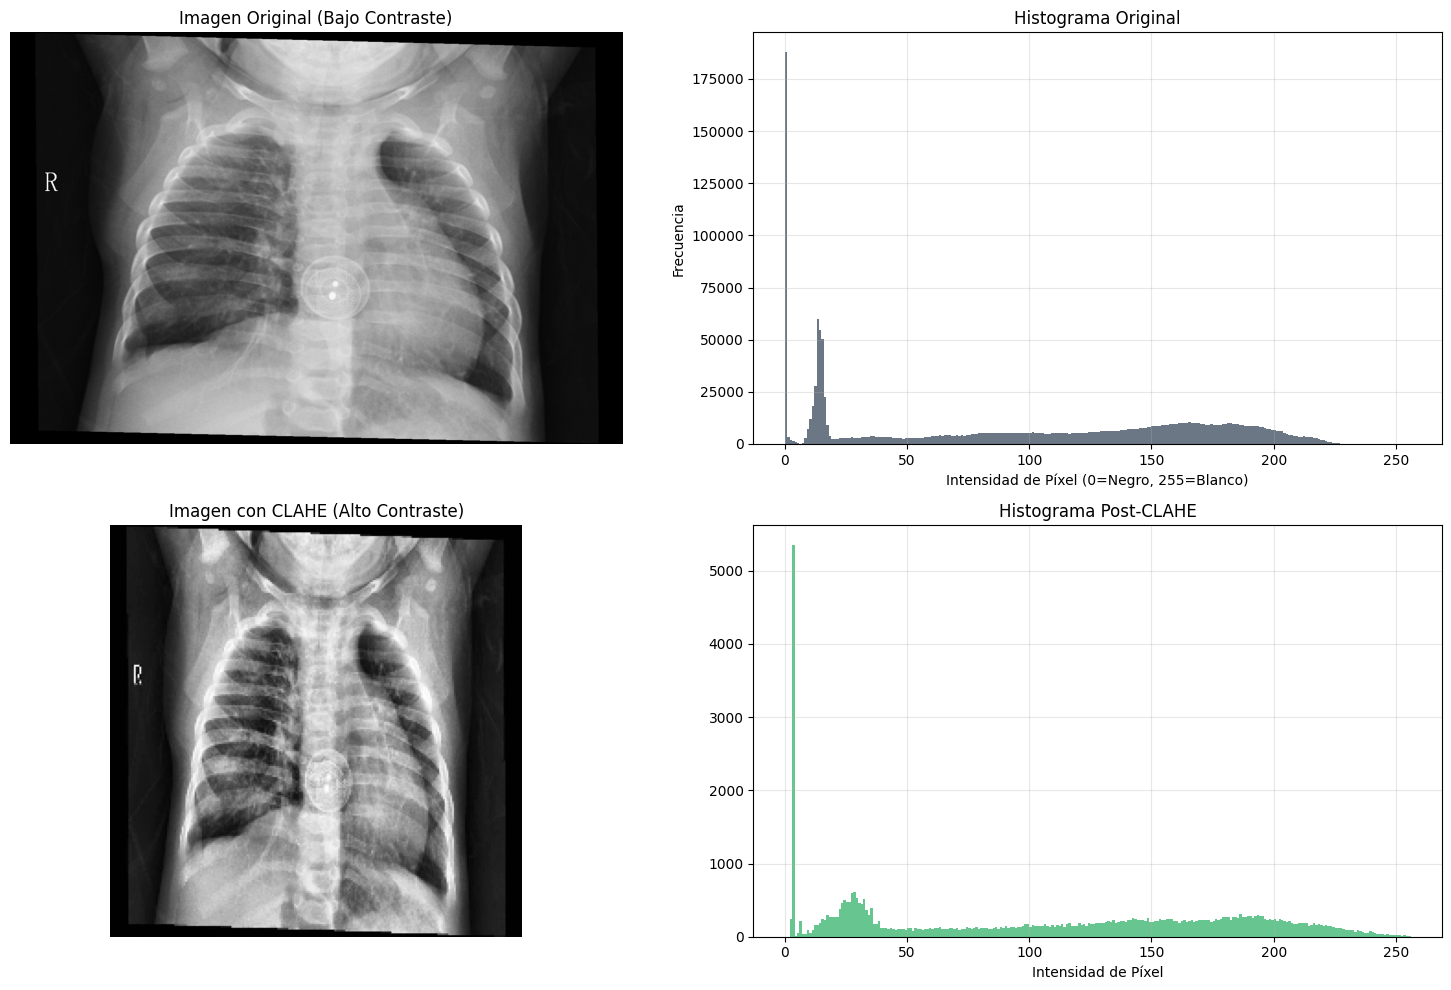

In [16]:
def graficar_comparacion_histogramas(img_orig, img_proc):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # --- FILA 1: ORIGINAL ---
    # Imagen
    axes[0, 0].imshow(img_orig, cmap='gray')
    axes[0, 0].set_title("Imagen Original (Bajo Contraste)")
    axes[0, 0].axis('off')
    
    # Histograma
    # .ravel() convierte la matriz 2D en una fila larga de píxeles
    axes[0, 1].hist(img_orig.ravel(), 256, [0, 256], color='#2c3e50', alpha=0.7)
    axes[0, 1].set_title("Histograma Original")
    axes[0, 1].set_xlabel("Intensidad de Píxel (0=Negro, 255=Blanco)")
    axes[0, 1].set_ylabel("Frecuencia")
    axes[0, 1].grid(True, alpha=0.3)
    
    # --- FILA 2: CON CLAHE ---
    # Imagen
    axes[1, 0].imshow(img_proc, cmap='gray')
    axes[1, 0].set_title("Imagen con CLAHE (Alto Contraste)")
    axes[1, 0].axis('off')
    
    # Histograma
    axes[1, 1].hist(img_proc.ravel(), 256, [0, 256], color='#27ae60', alpha=0.7)
    axes[1, 1].set_title("Histograma Post-CLAHE")
    axes[1, 1].set_xlabel("Intensidad de Píxel")
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usamos las variables que ya creaste en la celda anterior
if 'img_original' in locals() and 'img_con_clahe' in locals():
    graficar_comparacion_histogramas(img_original, img_con_clahe)
else:
    print("⚠️ Por favor ejecuta la celda anterior para cargar las imágenes de prueba.")

### 6. Análisis de Resultados: Efectividad de CLAHE

Tras aplicar la Ecualización de Histograma Adaptativa Limitada por Contraste (CLAHE), comparamos visual y estadísticamente los resultados para validar la etapa de preprocesamiento.

#### A. Análisis Visual (Cualitativo)
* **Imagen Original (Superior):** La radiografía presenta un rango dinámico pobre. Las estructuras óseas (costillas, clavículas) y el tejido pulmonar se mezclan en tonos grises medios, dificultando la distinción de bordes y texturas sutiles. Se observa un efecto de "neblina" generalizado.
* **Imagen Procesada con CLAHE (Inferior):** Se evidencia una mejora drástica en el contraste local.
    * **Definición de Bordes:** Las costillas son claramente discernibles del fondo.
    * **Textura Pulmonar:** La trama vascular y el tejido pulmonar (zona crítica para detectar neumonía) muestran ahora una textura rica y detallada, en lugar de una mancha plana.

#### B. Análisis de Histogramas (Cuantitativo)
* **Histograma Original:** Muestra una distribución **bimodal y estrecha**, concentrada principalmente entre los valores de intensidad 50 y 200.
    * *Interpretación:* Gran parte del espectro de colores (negros profundos 0-50 y blancos brillantes 200-255) está subutilizada. Esto confirma matemáticamente el bajo contraste percibido.
* **Histograma Post-CLAHE:** Muestra una distribución **"aplanada" y extendida**.
    * *Interpretación:* La curva se ha ensanchado para ocupar casi todo el rango disponible (0 a 255). Aunque se conservan los picos principales (que representan la anatomía base), la redistribución de frecuencias indica que hemos maximizado la entropía (información) de la imagen sin introducir ruido excesivo (gracias al límite de clip de CLAHE).

#### C. Implicación para la Clasificación
Este preprocesamiento es vital para los algoritmos que utilizaremos a continuación:
1.  **HOG (Histogram of Oriented Gradients):** Al tener bordes más nítidos en las costillas y diafragma, los gradientes serán más fuertes y descriptivos.
2.  **LBP (Local Binary Patterns):** Al revelar la micro-textura del tejido pulmonar, LBP podrá diferenciar mejor entre un pulmón sano (limpio) y uno con neumonía (infiltrados/rugoso).